In [2]:
!conda activate py310

In [3]:
# Importing necessary libraries for data preprocessing, modeling, data visualization, analysis and evaluation
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16

import seaborn as sns

from PIL import Image
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

The base directory is set to 'rps-cv-images-2' which contains the training and testing directories of rock paper scissors images.

In [5]:
# Defining training and testing directories
base_dir = 'rps-cv-images-2'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

# Checking if the training directory exists
if not os.path.exists(train_dir):
    raise Exception(f"Training directory {train_dir} does not exist.")

Iterating through subdirectories and files in the training directory to check if it is a valid image or not and also trying to open the file if it is a valid image for verifying weather the image is corrupted or not. If the image is corrupted, it will be deleted.

In [31]:
# Iterating through subdirectories of the training directory to check for corrupted images
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    # Iterating files in the subdirectory
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)
        # Checking if the file is an image
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Skipping {file_path} due to invalid file extension")
            continue
        # Checking if the image is corrupted or not
        try:
            with Image.open(file_path) as img:
                img.verify() 
        except (IOError, SyntaxError) as e:
            print(f"Deleting corrupted file {file_path}: {e}")
            os.remove(file_path)

# Iterating through subdirectories in the training directory
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    # 
    num_images = len([name for name in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, name))])
    print(f"Number of images in {subdir}: {num_images}")

Number of images in paper: 710
Number of images in rock: 724
Number of images in scissors: 748


Creating a barchart to visualize the number of images in each class within the training directory.

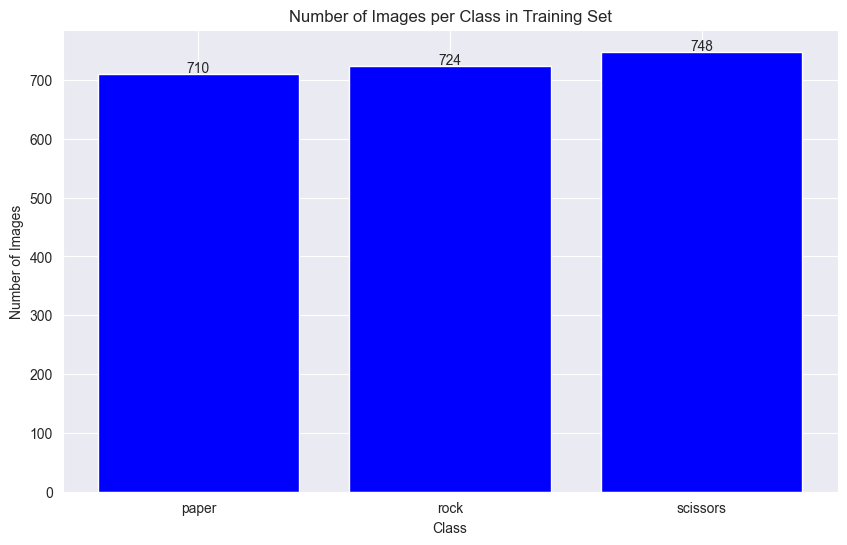

In [7]:
# Initializing the directory for storing class counts
class_counts = {}
# Bar chart for visualizing the class counts
plt.figure(figsize=(10, 6))
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    num_images = len([name for name in os.listdir(subdir_path) if name.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[subdir] = num_images
    plt.bar(subdir, num_images, color='blue')
    plt.text(subdir, num_images + 3, str(num_images), ha='center')

plt.title('Number of Images per Class in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

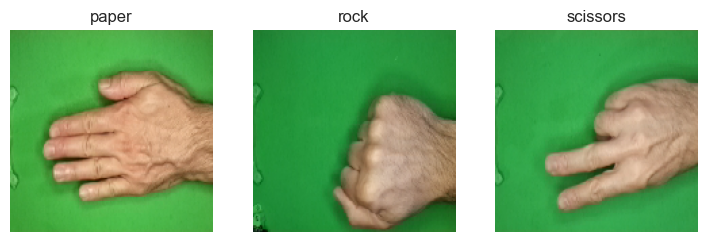

In [8]:
plt.figure(figsize=(12, 10))
classes = os.listdir(train_dir)
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    file_name = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
    img_path = os.path.join(class_dir, file_name)
    img = image.load_img(img_path, target_size=(150, 150))
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

Creating an ImageDataGenerator with various data augmentation parameters to enhance the robustness of the model. It includes processes like random zooming, rotation, horizontal flipping, vertical flipping and pixel normalization. The data is split into training and validation sets by an 80:20 ratio.

Two image generators are made using the flow_from_directory function: one for training data and another for validation data. These generators read images from the directory and apply the specified data augmentation parameters & return the batches of augmented images and their corresponding labels which will helps us to train the model more efficiently.

In [9]:
# ImageDataGenerator with data augmentation parameters
generator = ImageDataGenerator(
    rescale = 1/255.0,  # Normalizing the pixels values to the range [0, 1]
    zoom_range=0.25,    # Randomly zooming images by 25%
    rotation_range = 10,    # Randomly rotate image by 10 degrees
    horizontal_flip = True, # Randomly flip images horizontally
    vertical_flip = True,   # Randomly flip images vertically
    fill_mode = 'nearest',  # Using nearest neighbor interpolation for filling pixels when rotating or zooming
    validation_split=0.2    # Splitting the data into training and validation sets by 80:20 ratio
)

# Generating to read and augment the training images
train_generator = generator.flow_from_directory(
    train_dir,                        # Directory containing training images
    target_size=(150, 150),           # Resizing all images to 150x150 pixels
    batch_size=32,                    # Processing images in batches of 32 samples
    class_mode='categorical',         # Using one-hot encoded labels
    color_mode='rgb',                 # Inputting images are RGB color
    subset='training'                 # Using the training subset of the data
)

# Generating to read and augment the validation images
val_generator = generator.flow_from_directory(
    train_dir,                        # Directory containing training images
    target_size=(150, 150),           # Resizing images to 150x150 pixels
    batch_size=32,                    # Processing images in batches of 32 samples
    class_mode='categorical',         # Using one-hot encoded labels
    color_mode='rgb',                 # Input images are RGB color
    subset='validation'               # Using the validation subset of the data
)

Found 1747 images belonging to 3 classes.
Found 435 images belonging to 3 classes.


In [10]:
# Random seed for reproducibility
tf.random.set_seed(18)

## Fully Connected Neural Network

The model architecture is a sequential model with multiple layers; input layer is followed by three hidden layers with 1024, 512 and 256 neurons respectively. Each hidden layer is followed by a ReLU activation function, batch normalization and dropout layer with a dropout rate of 50%. The output layer has 3 neurons with a softmax activation function. The output layer uses a softmax activation function to output the probability of each class. The model is compiled using the Adam optimizer and categorical cross-entropy loss function.

After compiling the model, it is trained using the train_generator and validated using the val_generator. The history of the model is stored to visualize the loss and accuracy of the model over the epochs. The model is trained for 50 epochs with 25 steps per epoch and 5 validation steps per epoch with learning rate of 0.00001.

The training history is stored in the historyModel variable and is visualized using matplotlib to plot the loss and accuracy of the model over the epochs.

In [11]:
# Defining the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)), # Input Layer
    tf.keras.layers.Dense(1024, activation='relu'), # Hidden Layer 1 with 1024 neurons and ReLU activation function
    tf.keras.layers.BatchNormalization(),   # Batch Normalization Layer
    tf.keras.layers.Dropout(0.5),   # Dropout Layer with 50% dropout rate
    tf.keras.layers.Dense(512, activation='relu'),  # Hidden Layer 2 with 512 neurons and ReLU activation function
    tf.keras.layers.BatchNormalization(),   # Batch Normalization Layer
    tf.keras.layers.Dropout(0.5),   # Dropout Layer with 50% dropout rate
    tf.keras.layers.Dense(256, activation='relu'),  # Hidden Layer 3 with 256 neurons and ReLU activation function
    tf.keras.layers.BatchNormalization(),   # Batch Normalization Layer
    tf.keras.layers.Dropout(0.5),   # Dropout Layer with 50% dropout rate
    tf.keras.layers.Dense(3, activation='softmax')  # Output Layer with 3 neurons and Softmax activation function
])

# Compiling the model using the Adam optimizer and categorical cross entropy-loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# Training the model using the train_generator and validating it using the val_generator & storing the history of the model
historyModel = model.fit(
    train_generator,    # Train the model on the augmented training images
    steps_per_epoch = 25,   # Number of steps (batches) to yield from the generator at each epoch
    epochs = 50,    # Number of epochs to train the model
    validation_data = val_generator,    # Validate the model on the augmented validation images
    validation_steps = 5,   # Number of steps (batches) to yield from the generator at each epoch
    verbose = 2    # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
)

Epoch 1/50
25/25 - 7s - loss: 1.8246 - accuracy: 0.3723 - val_loss: 1.1912 - val_accuracy: 0.3313 - 7s/epoch - 275ms/step
Epoch 2/50
25/25 - 5s - loss: 1.5005 - accuracy: 0.4879 - val_loss: 1.1927 - val_accuracy: 0.3688 - 5s/epoch - 181ms/step
Epoch 3/50
25/25 - 5s - loss: 1.4381 - accuracy: 0.5163 - val_loss: 1.1742 - val_accuracy: 0.3187 - 5s/epoch - 187ms/step
Epoch 4/50
25/25 - 4s - loss: 1.2341 - accuracy: 0.5731 - val_loss: 1.0338 - val_accuracy: 0.3438 - 4s/epoch - 180ms/step
Epoch 5/50
25/25 - 5s - loss: 1.3468 - accuracy: 0.5425 - val_loss: 0.9258 - val_accuracy: 0.5813 - 5s/epoch - 182ms/step
Epoch 6/50
25/25 - 4s - loss: 1.2424 - accuracy: 0.5756 - val_loss: 1.1601 - val_accuracy: 0.3562 - 4s/epoch - 179ms/step
Epoch 7/50
25/25 - 4s - loss: 1.2605 - accuracy: 0.5629 - val_loss: 0.9184 - val_accuracy: 0.5437 - 4s/epoch - 180ms/step
Epoch 8/50
25/25 - 4s - loss: 1.2342 - accuracy: 0.5807 - val_loss: 0.7260 - val_accuracy: 0.6625 - 4s/epoch - 180ms/step
Epoch 9/50
25/25 - 4s - 

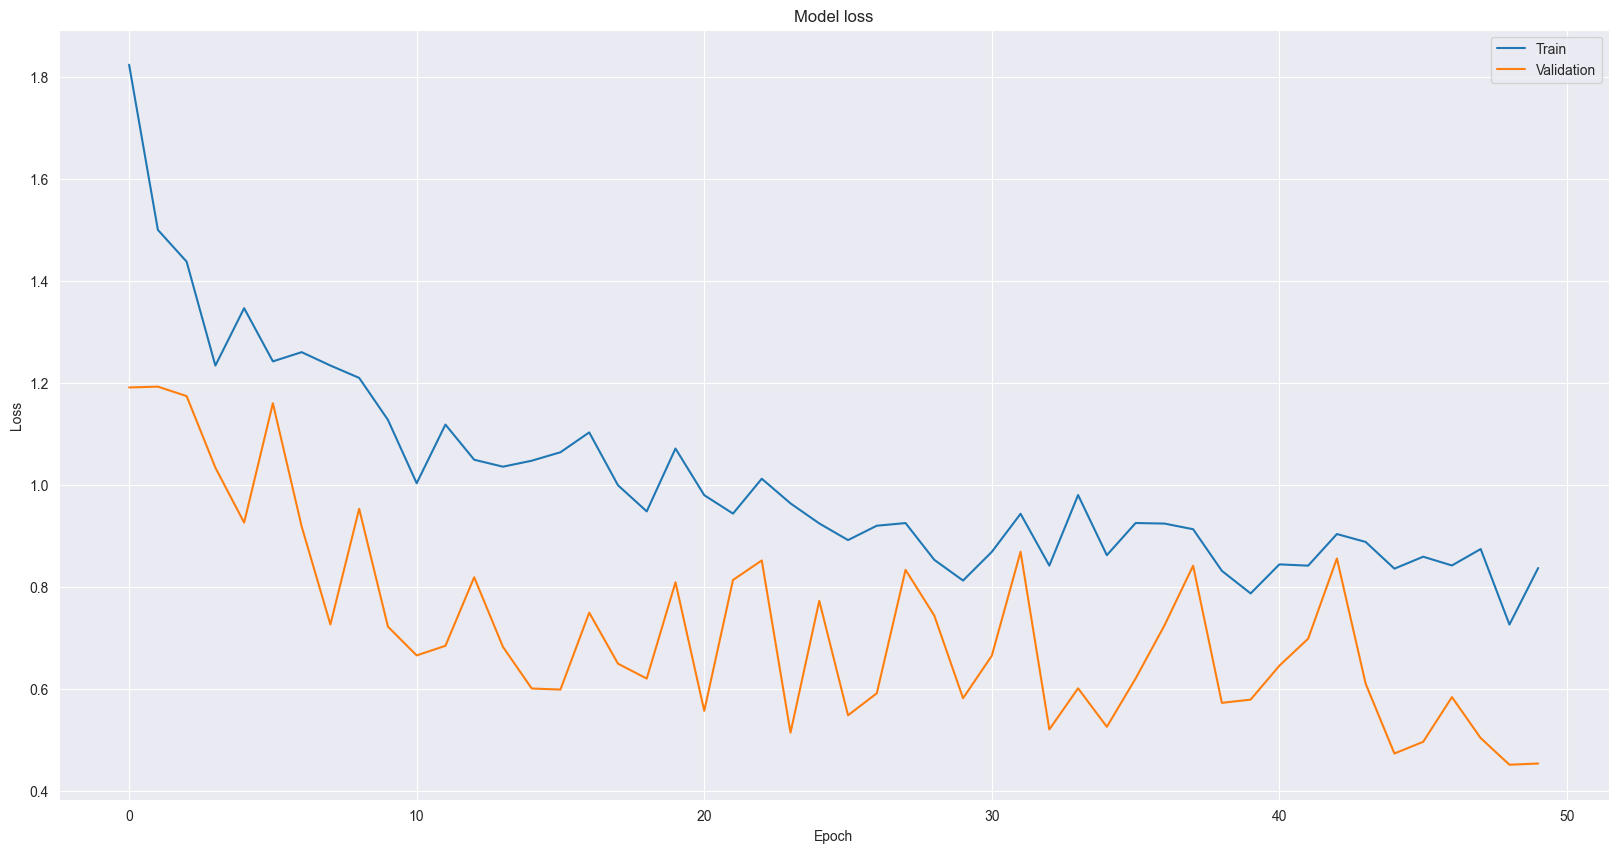

In [12]:
plt.figure(figsize=(20,10))
plt.plot(historyModel.history['loss'])
plt.plot(historyModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

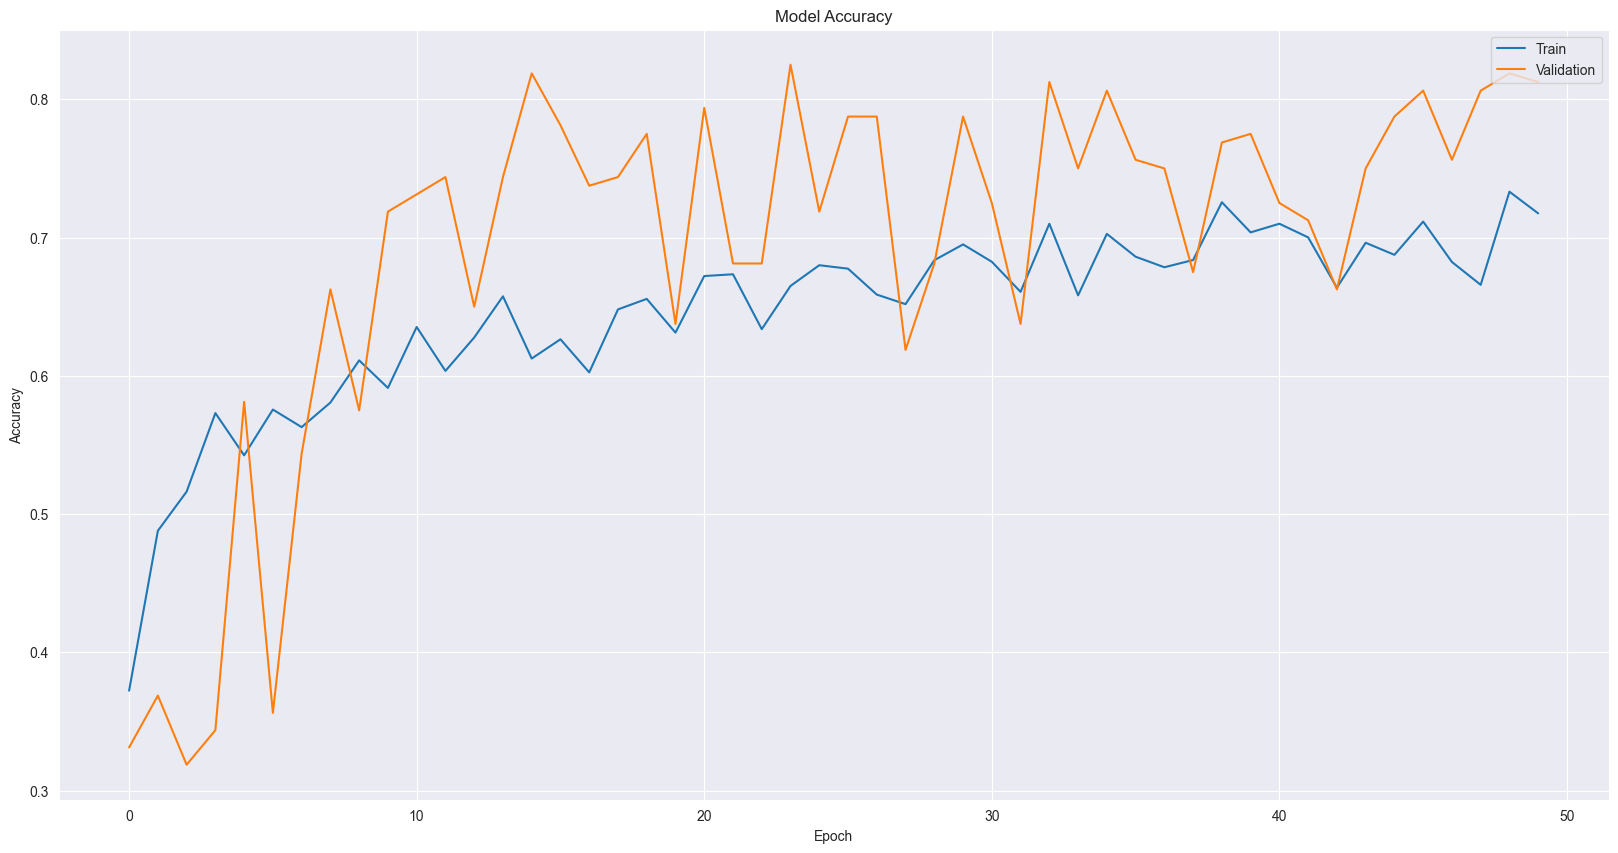

In [13]:
plt.figure(figsize=(20,10))

plt.plot(historyModel.history['accuracy'])
plt.plot(historyModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 101ms/step
Class Indices from Training: {'paper': 0, 'rock': 1, 'scissors': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


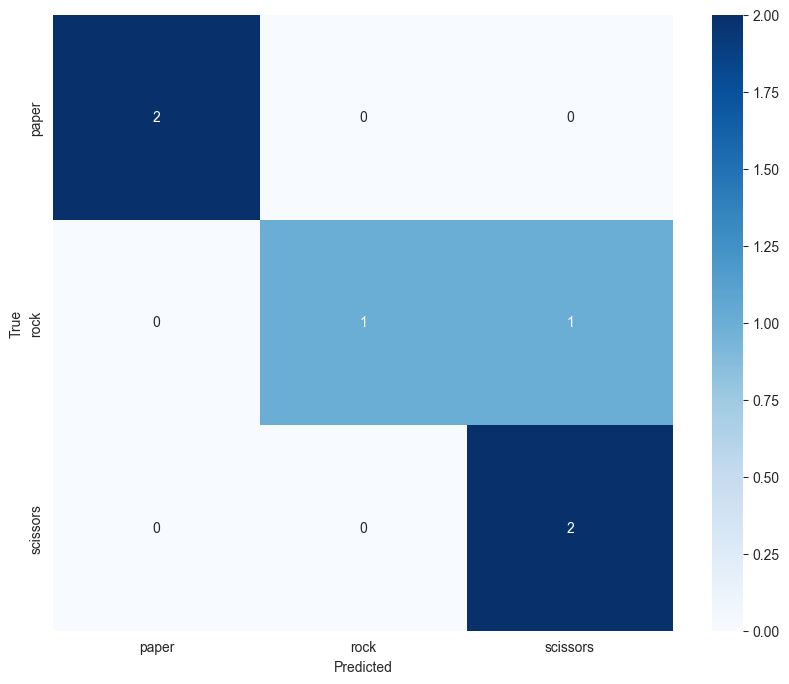

In [14]:
def load_test_images_structured(directory, target_size=(150, 150)):
    images = []
    labels = []
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img = image.load_img(img_path, target_size=target_size)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                images.append(img_array)
                labels.append(class_dir)
    return np.vstack(images), labels

test_images, test_labels = load_test_images_structured(test_dir)

test_images = test_images / 255.0

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

print("Class Indices from Training:", train_generator.class_indices)

adjusted_test_labels = [label.lower() for label in test_labels] 

label_map = {k.lower(): v for k, v in train_generator.class_indices.items()}
true_classes = [label_map[label] for label in adjusted_test_labels]

cm = confusion_matrix(true_classes, predicted_classes, labels=list(label_map.values()))
print(classification_report(true_classes, predicted_classes, labels=list(label_map.values())))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Conclusion

The first graph shows the model loss curves for training and validation sets over multiple epochs. We can observe that both the training and validation losses with a lot of fluctuations.

The second graph shows the model accuracy curves for training and validation sets over multiple epochs. We can observe that the training accuracy increases over time with the lot of fluctuations.

The confusion matrix shows that the model correctly predicted 2 instances of paper and 2 instances of scissors. However it misclassified 1 instance of rock as scissor.

From the above graphs we can conclude that the model is moderately able ot perform correct classification but the graphs suggests that there are a lot of adjustments to do. The model can be further improved by using more complex models like Convolutional Neural Networks (CNN) or Transfer Learning models like VGG16, ResNet, etc.

## Convolutional Neural Network (CNN)

The convolutional neural network architecture consists of series of convolutional, max pooling and dropout layers to extract features from the images. The model architecture is a sequential model with multiple layers; input layer is followed by four convolutional layers with 32, 64, 128 and 128 filters respectively. Each convolutional layer is followed by a max pooling layer with 2x2 pool size and a dropout layer with a dropout rate of 20%. The convolutional layers are followed by a flatten layer to flatten the input and a dense layer with 512 neurons and a ReLU activation function. The dense layer is followed by a dropout layer with a dropout rate of 50% and an output layer with 3 neurons and a softmax activation function. The model is compiled using the Adam optimizer and categorical cross-entropy loss function.

In [15]:
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),    # Convolutional layer with 32 filters, 3x3 kernel size and ReLU activation function; input shape is 150x150 pixels and 3 channels
    tf.keras.layers.MaxPooling2D(2, 2), # Max pooling layer with 2x2 pool size
    tf.keras.layers.Dropout(0.2),   # Dropout layer with 20% dropout rate
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),   # Convolutional layer with 64 filters, 3x3 kernel size and ReLU activation function
    tf.keras.layers.MaxPooling2D(2,2),  # Max pooling layer with 2x2 pool size
    tf.keras.layers.Dropout(0.2),   # Dropout layer with 20% dropout rate
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  # Convolutional layer with 128 filters, 3x3 kernel size and ReLU activation function
    tf.keras.layers.MaxPooling2D(2,2),  # Max pooling layer with 2x2 pool size
    tf.keras.layers.Dropout(0.2),   # Dropout layer with 20% dropout rate
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  # Convolutional layer with 128 filters, 3x3 kernel size and ReLU activation function
    tf.keras.layers.MaxPooling2D(2,2),  # Max pooling layer with 2x2 pool size
    tf.keras.layers.Flatten(),  # Flatten layer to flatten the input
    tf.keras.layers.Dense(512, activation='relu'),  # Dense layer with 512 neurons and ReLU activation function
    tf.keras.layers.Dropout(0.5),   # Dropout layer with 50% dropout rate
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)  # Output layer with 3 neurons and Softmax activation function
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 64)       

A custom callback class is defined that overrides the tf.keras.callbacks.Callback class. The on_epoch_end method is overridden to stop training if the accuracy of the model is greater than or equal to 99%. An instance of the CallbackAcc class is created and passed as a callback function to the model.

The model is compiled using the Adam optimizer and categorical cross entropy-loss function. The model is trained using the CallbackAcc object and the history of the model is stored. The history of the model is visualized using matplotlib to plot the loss and accuracy of the model over the epochs.

In [17]:
# A custom callback class that overrides the ft.keras.callbacks.Callback class
class CallbackAcc(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # If the accuracy of the model is greater than or equal to 99%, stop training
        if(logs.get('accuracy') >= 0.99):
            print("\nReached %2.2f%% accuracy, training has been stop" %(logs.get('accuracy')*100))
            self.model.stop_training = True
            
# Creating an instance of the CallbackAcc class
callbacks = CallbackAcc()

In [18]:
# Compiling the model using the Adam optimizer and categorical cross entropy-loss function
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [19]:
# Training the model using the CallbackAcc object and storing the history of the model
historyModel = model.fit(
    train_generator,    # Train the model on the augmented training images
    steps_per_epoch = 25,   # Number of steps (batches) to yield from the generator at each epoch
    epochs = 50,    # Number of epochs to train the model
    validation_data = val_generator,    # Validate the model on the augmented validation images
    validation_steps = 5,   # Number of steps (batches) to yield from the generator at each epoch
    verbose = 2,    # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
    callbacks = [callbacks])    # Callback function to stop training if accuracy is greater than or equal to 99%

Epoch 1/50
25/25 - 10s - loss: 1.0948 - accuracy: 0.3736 - val_loss: 1.0108 - val_accuracy: 0.5500 - 10s/epoch - 397ms/step
Epoch 2/50
25/25 - 4s - loss: 0.8561 - accuracy: 0.6353 - val_loss: 0.8159 - val_accuracy: 0.6938 - 4s/epoch - 179ms/step
Epoch 3/50
25/25 - 5s - loss: 0.6613 - accuracy: 0.7462 - val_loss: 0.5655 - val_accuracy: 0.7750 - 5s/epoch - 180ms/step
Epoch 4/50
25/25 - 5s - loss: 0.4307 - accuracy: 0.8238 - val_loss: 0.3268 - val_accuracy: 0.9125 - 5s/epoch - 194ms/step
Epoch 5/50
25/25 - 5s - loss: 0.3314 - accuracy: 0.8831 - val_loss: 0.2657 - val_accuracy: 0.9187 - 5s/epoch - 201ms/step
Epoch 6/50
25/25 - 5s - loss: 0.2903 - accuracy: 0.9025 - val_loss: 0.2352 - val_accuracy: 0.9250 - 5s/epoch - 182ms/step
Epoch 7/50
25/25 - 4s - loss: 0.2791 - accuracy: 0.8907 - val_loss: 0.2754 - val_accuracy: 0.8938 - 4s/epoch - 180ms/step
Epoch 8/50
25/25 - 5s - loss: 0.2831 - accuracy: 0.9022 - val_loss: 0.2236 - val_accuracy: 0.9250 - 5s/epoch - 180ms/step
Epoch 9/50
25/25 - 5s 

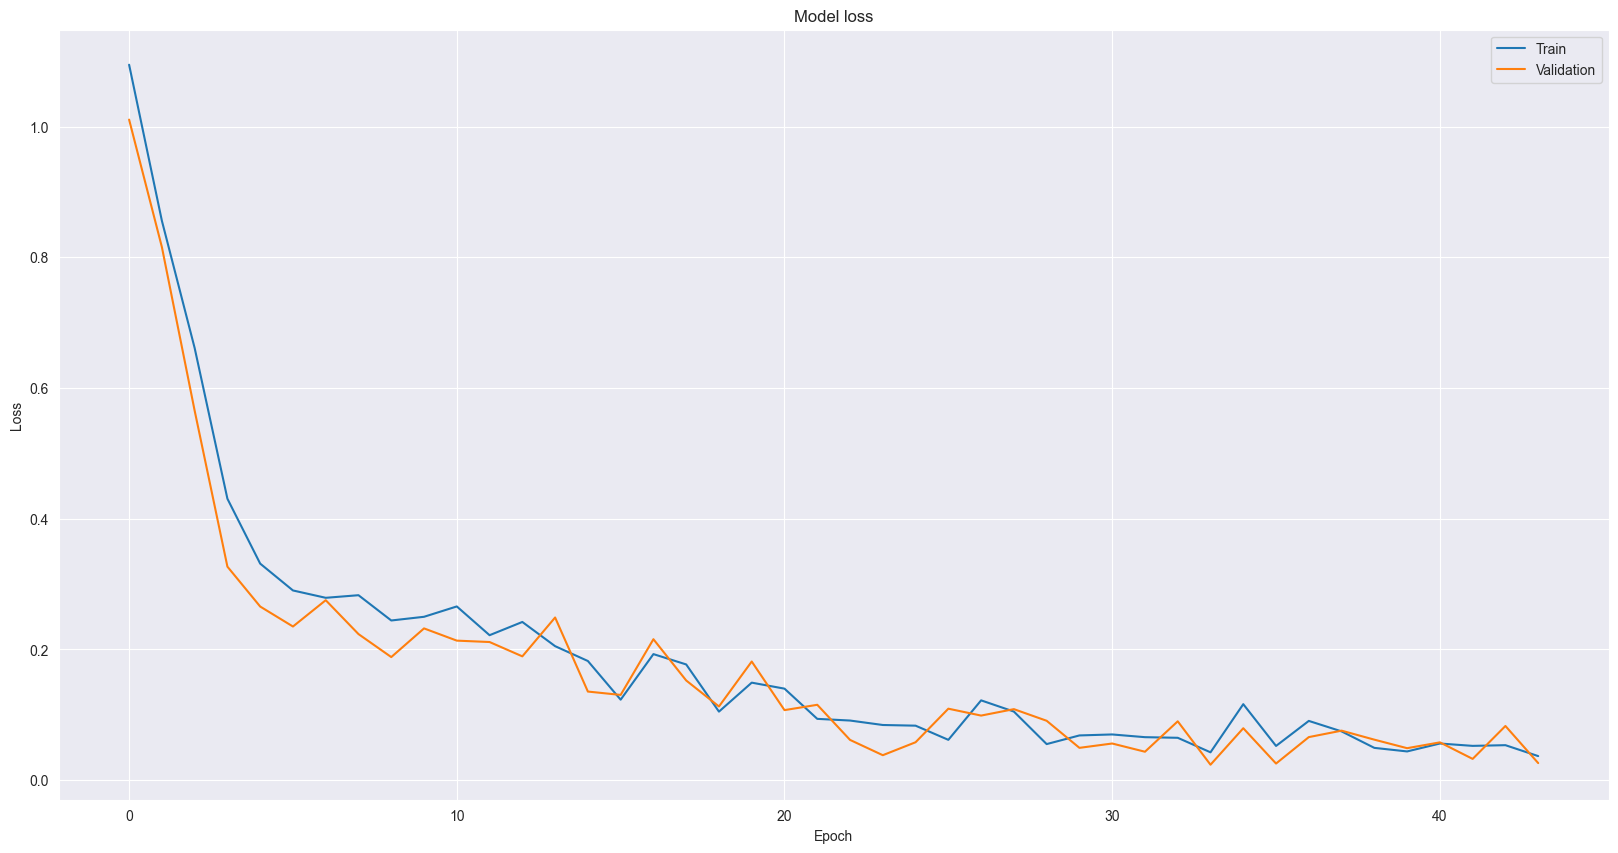

In [20]:
plt.figure(figsize=(20,10))
plt.plot(historyModel.history['loss'])
plt.plot(historyModel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

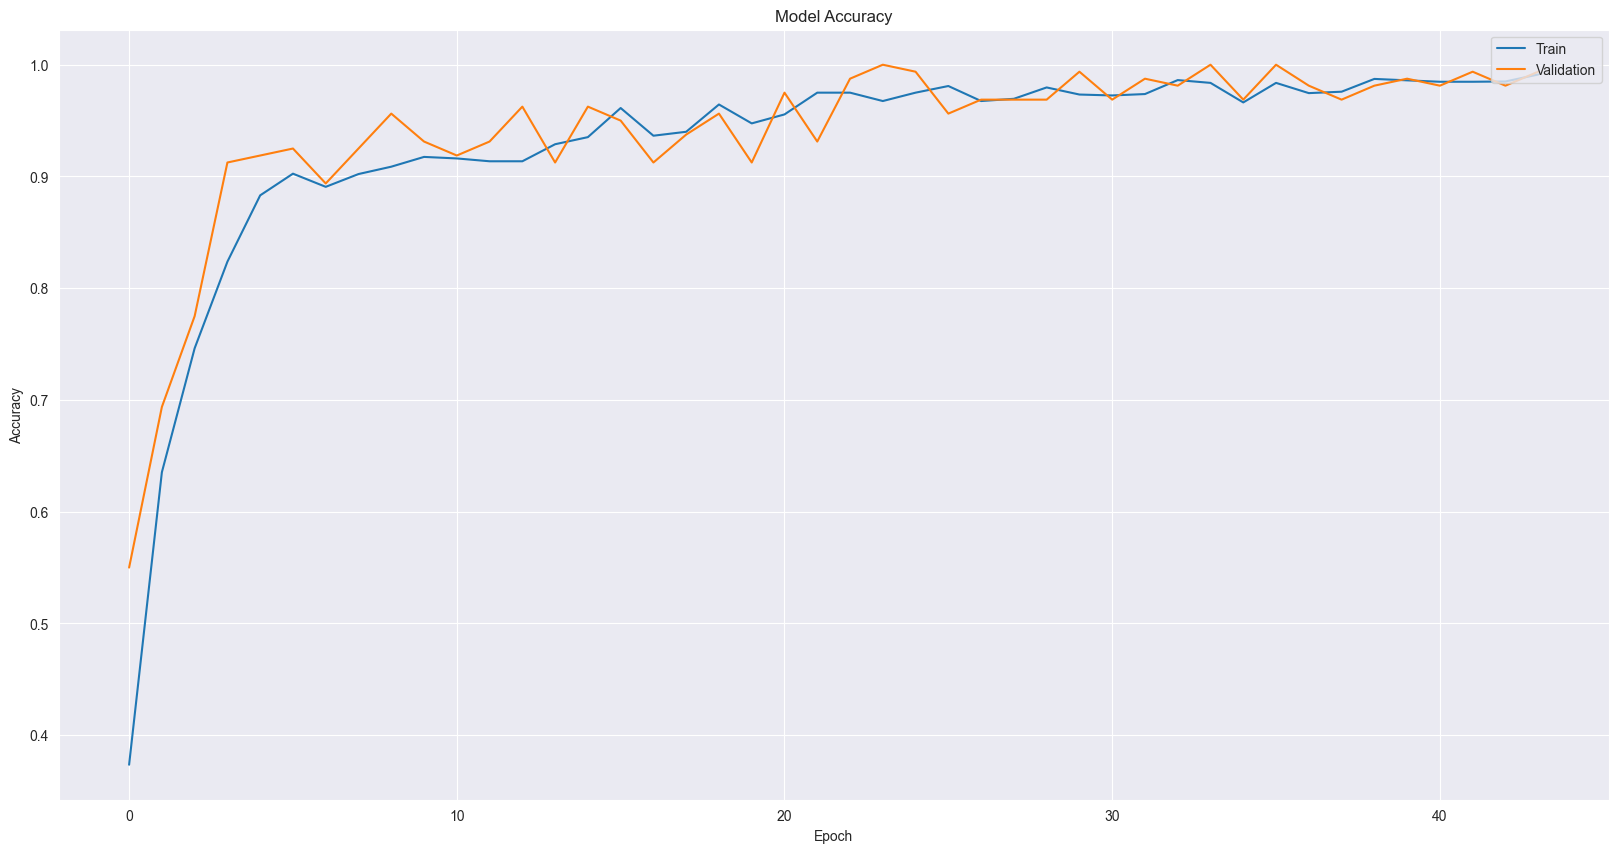

In [21]:
plt.figure(figsize=(20,10))

plt.plot(historyModel.history['accuracy'])
plt.plot(historyModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 293ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


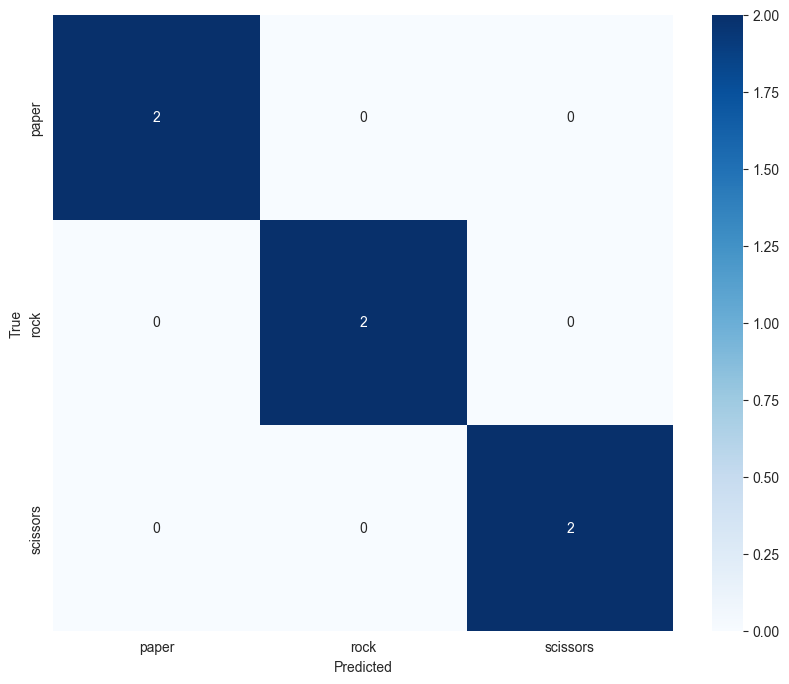

In [22]:
def load_test_images_structured(directory, target_size=(150, 150)):
    images = []
    labels = []
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img = image.load_img(img_path, target_size=target_size)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0) 
                images.append(img_array)
                labels.append(class_dir) 
    return np.vstack(images), labels

test_images, test_labels = load_test_images_structured(test_dir)

test_images = test_images / 255.0

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

adjusted_test_labels = [label.lower() for label in test_labels]

label_map = {k.lower(): v for k, v in train_generator.class_indices.items()}
true_classes = [label_map[label] for label in adjusted_test_labels]

cm = confusion_matrix(true_classes, predicted_classes, labels=list(label_map.values()))
print(classification_report(true_classes, predicted_classes, labels=list(label_map.values())))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Conclusion

The first graph shows the model loss curves for training and validation sets over multiple epochs. After 10-15 epochs both the training and validation loss curves have started to flatten out which suggests that the model has coverged and further training may not be beneficial. The validation loss curve closely follows the training loss curve which is a good sign indicating the the model is generalizing well to unseen datas.

The second graph shows the model accuracy curves for training and validation sets over multiple epochs and shows the decreasing loss. The training and validation accuracy curves reach relatively high values (around 0.9 or 90%) which shows that the model is performing well on the classification task. The gap between the training and validation accuracy curves is small which indicates that the model is generalizing well to unseen data.

The confusion matrix shows that the model correctly predicted all the instances of rock, paper and scissors. The classification report shows that the model has high precision, recall and F1-score for all the classes. There is no mis-classification in the confusion matrix which shows that the model has achieved perfect classification on the test set.

Finally we can say that the CNN model has performed better than the Fully Connected Neural Network model and has achieved perfect classification on the test set.

## Transfer Learning

The VGG16 model is loaded with pre-trained weights on the ImageNet dataset excluding the top layer. The weights of the base model are frozen to prevent them from being updated during training. The model architecture is defined by adding the base model and additional layers. The hidden layers include GlobalAveragePooling2D to reduce the dimensions of the feature maps, a dense layer with 512 neurons and ReLU activation function, a dropout layer with a dropout rate of 50%, and an output layer with 3 neurons and a softmax activation function.

In [23]:
# Loading the VGG16 model with pre-trained weights on ImageNet dataset excluding the top layer
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# Freezing the weights of the base model in order to prevent weights from being updated during training
base_model.trainable = False

# Defining the model architecture by adding the base model and additional layers
model = tf.keras.models.Sequential([
    base_model,  # Adding the VGG16 base model as the initial layer
    tf.keras.layers.GlobalAveragePooling2D(), # Global Average Pooling layer to reduce the dimensions of the feature maps
    tf.keras.layers.Dense(512, activation='relu'),  # Dense layer with 512 neurons and ReLU activation function
    tf.keras.layers.Dropout(0.5),   # Dropout layer with 50% dropout rate
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 neurons and Softmax activation function
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,978,883
Trainable params: 264,195
Non-trainable params: 14,714,688
____________________________________

The model is compiled using the categorical cross-entropy loss function and Adam optimizer. The model is trained using the fit_generator() function which takes the training validation data generators. The model is trained for 40 epochs with the verbosity level 1 as argument and the history of the model is stored. The history of the model is visualized using matplotlib to plot the loss and accuracy of the model over the epochs.

In [24]:
# Compiling the model using categorical_crossentropy loss, Adam optimizer and accuracy metric
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Training the model using the train_generator and validating it using the val_generator
history = model.fit_generator(
    train_generator,    # Training data generator
    validation_data  = val_generator,   # Validation data generator
    epochs = 40,    # Number of epochs to train the model
    verbose = 1 # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
)

C:\Users\diwas\AppData\Local\Temp\ipykernel_19444\1099919365.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
55/55 [==============================] - 15s 224ms/step - loss: 0.4408 - accuracy: 0.8306 - val_loss: 0.1345 - val_accuracy: 0.9770
Epoch 2/40
55/55 [==============================] - 10s 187ms/step - loss: 0.1282 - accuracy: 0.9651 - val_loss: 0.0751 - val_accuracy: 0.9839
Epoch 3/40
55/55 [==============================] - 10s 186ms/step - loss: 0.0821 - accuracy: 0.9777 - val_loss: 0.0672 - val_accuracy: 0.9747
Epoch 4/40
55/55 [==============================] - 10s 186ms/step - loss: 0.0698 - accuracy: 0.9788 - val_loss: 0.0374 - val_accuracy: 0.9885
Epoch 5/40
55/55 [==============================] - 10s 187ms/step - loss: 0.0546 - accuracy: 0.9805 - val_loss: 0.0384 - val_accuracy: 0.9908
Epoch 6/40
55/55 [==============================] - 11s 202ms/step - loss: 0.0447 - accuracy: 0.9845 - val_loss: 0.0274 - val_accuracy: 0.9862
Epoch 7/40
55/55 [==============================] - 12s 220ms/step - loss: 0.0401 - accuracy: 0.9886 - val_loss: 0.0354 - val_accuracy: 0.9931

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

<function matplotlib.pyplot.show(close=None, block=None)>

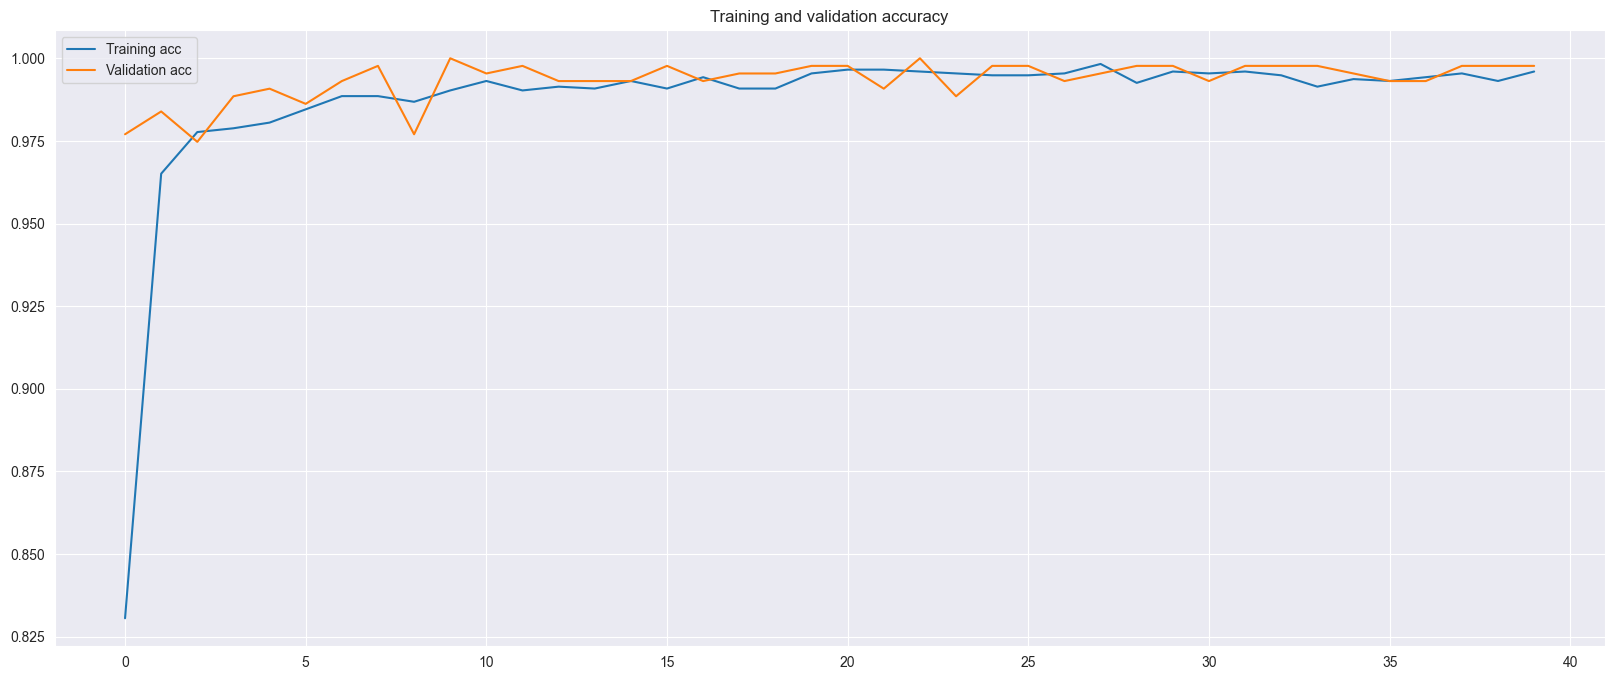

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show

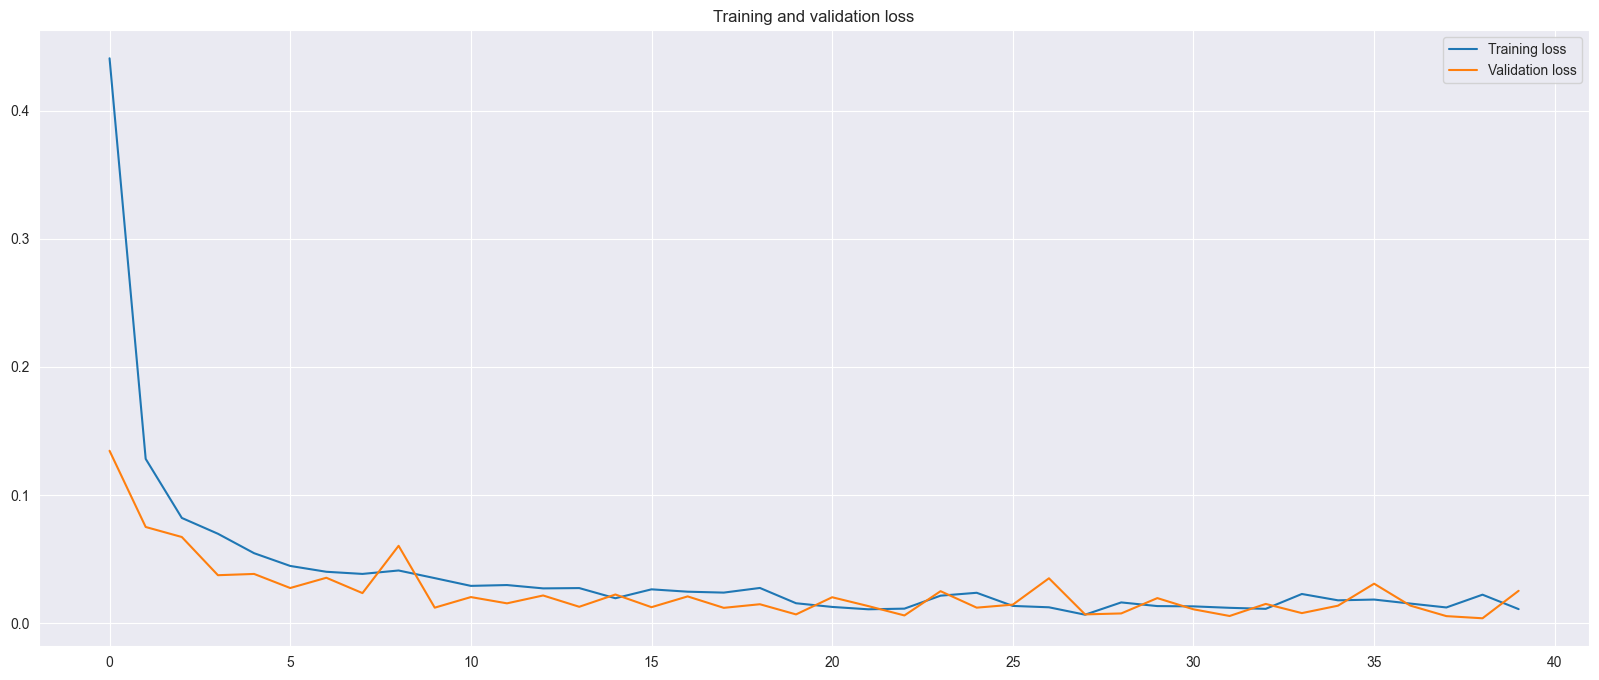

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


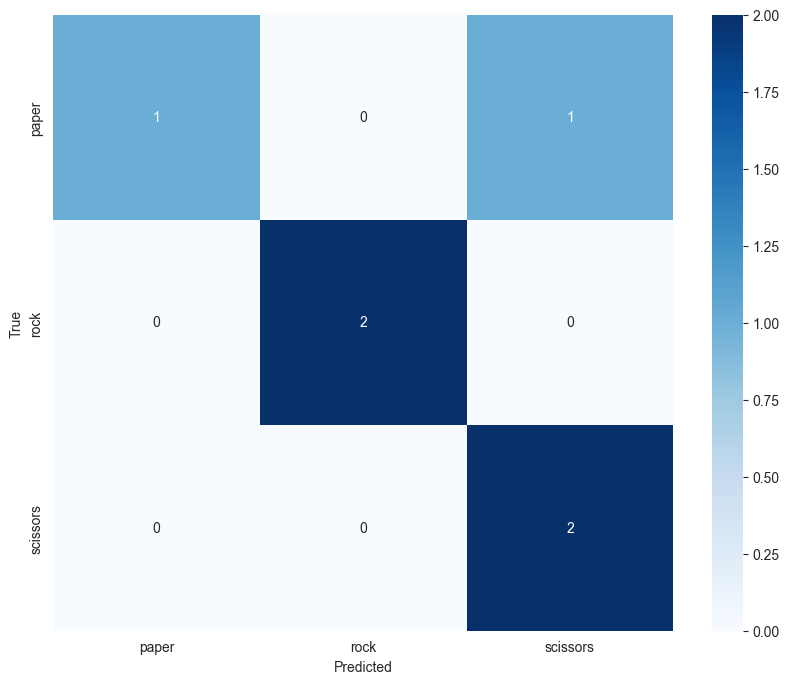

In [30]:
def load_test_images(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, filename)
                img = image.load_img(img_path, target_size=target_size)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                images.append(img_array)
                labels.append(class_dir)
    return np.vstack(images), labels

test_images, test_labels = load_test_images(test_dir)
test_images /= 255.0

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

label_map = {k.lower(): v for k, v in train_generator.class_indices.items()}
true_classes = [label_map[label.lower()] for label in test_labels]

cm = confusion_matrix(true_classes, predicted_classes, labels=list(label_map.values()))
print(classification_report(true_classes, predicted_classes, labels=list(label_map.values())))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Conclusion

The first graph shows the model loss curves for training and validation sets over multiple epochs. The validation accuracy line is slightly lower than the training accuracy line which indicates that the model is slightly overfitting the training data.

The second graph shows the model accuracy curves for training and validation sets over multiple epochs. The validation accuracy line is slightly lower than the training accuracy line which indicates that the model is slightly overfitting the training data.

The confusion matrix shows that the model performs well in classifying the images of rock and scissors but struggles with paper class where several instances are misclassified as scissors.

From the above graphs we can conclude that the model trained using transfer learning with VGG16 on the dataset shows signs of overfitting as shown by the gap between training and validation curves.  

# Final Conclusion

In this project, we have trained three models on the rock paper scissors dataset using different approaches: Fully Connected Neural Network, Convolutional Neural Network (CNN) and Transfer Learning with VGG16. The models were trained on the training data and evaluated on the test data. The models were evaluated based on their loss, accuracy, confusion matrix and classification report.
Based on the evaluation results, the CNN model performed better than the Fully Connected Neural Network model and the Transfer Learning model. The CNN model achieved perfect classification on the test set with high precision, recall and F1-score for all the classes. The Transfer Learning model showed signs of overfitting as indicated by the gap between the training and validation curves. The Fully Connected Neural Network model achieved moderate classification on the test set with some misclassifications.

In conclusion, the CNN model is the best model for classifying rock paper scissors images. The model can be further improved by fine-tuning the hyperparameters, increasing the number of epochs, adding more layers, and using more complex models like VGG16, ResNet, etc. The model can also be improved by using more data augmentation techniques, regularization techniques, and dropout layers to prevent overfitting. The model can be further evaluated on a larger test set to assess its performance on unseen data.

Overall, the project demonstrates the use of different deep learning models for image classification tasks and provides insights into the performance of each model on the rock paper scissors dataset.